Se cargan las siguientes librerías:

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")

Luego, se carga el archivo preprocesado del Conjunto de Datos de Recursos Humanos:

In [2]:
df = pd.read_csv('C:/Users/luis_/OneDrive/Documentos/rh_datos_procesados_pca.csv')

df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium', 'first_principle_component',
       'second_principle_component', 'third_principle_component'],
      dtype='object')

Se seleccionan las variables a incluir en el modelo y se ejecuta el train-test split on the data:

### Entrenando Modelo Óptimo listo para Producción con el clasificador Random Forest

In [3]:
from sklearn.model_selection import train_test_split

features = [
    
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]

X, X_test, y, y_test = train_test_split(df[features].values, df['left'].values, test_size = 0.15, random_state = 1)

Se calcula una curva de validación para el RandomForestClassifier con n_estimators=50, con rango de  2 en 2 hasta 52:

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

clf = RandomForestClassifier(n_estimators = 50)

max_depth_range = np.arange(2, 52, 2)

print('Entrenando {} modelos ...'.format(len(max_depth_range)))

train_scores, test_scores = validation_curve(estimator = clf, X = X, y = y, param_name = 'max_depth',
                                             param_range = max_depth_range, cv = 5)

Entrenando 25 modelos ...


Ahora, se grafica la curva de validación:

In [5]:
# Función para trazar la curva de validación

def plot_validation_curve(train_scores, test_scores, param_range, xlabel='',log=False):
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='precisión de entrenamiento')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='precisión de validación')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    
    plt.legend(loc='lower right')
    
    if xlabel:
        plt.xlabel(xlabel)
    
    plt.ylabel('Precisión')
    
    plt.ylim(0.9, 1.0)
    
    return fig
    

(0.97, 1.0)

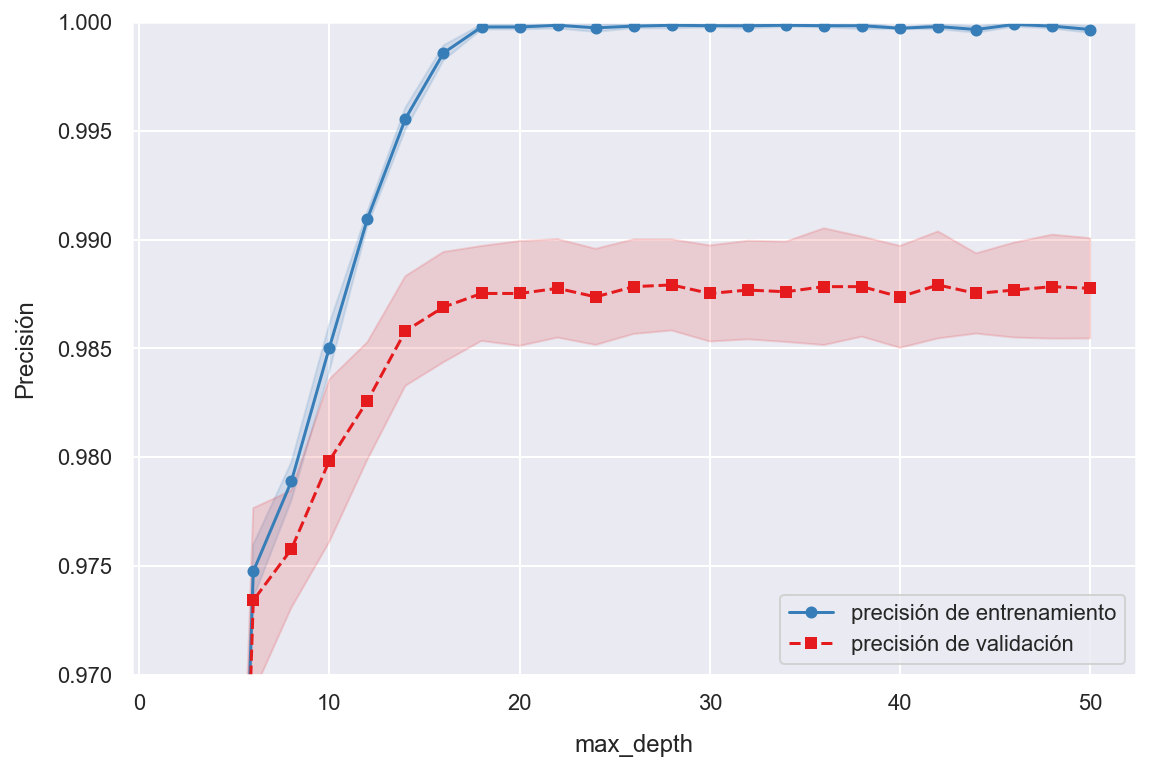

In [6]:
plot_validation_curve(train_scores, test_scores, max_depth_range, xlabel = 'max_depth')

plt.ylim(0.97, 1.0)

En este caso, para el modelo Random Forest, solo es importante establecer max_depth lo suficientemente alto para evitar un desajuste, y no deberíamos preocuparnos por el sobreajuste en valores grandes de max_depth. Dado esto, y el hecho de que la precisión de la validación parece converger alrededor de 20, seleccionaremos max_depth = 25 como el valor óptimo para este hiperparámetro.

Se define la clase personalizada para calcular k-fold cross validation class accuracies: 

In [7]:
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

def cross_val_class_score(clf, X, y, cv = 10):
    
    Kfold = (StratifiedKFold(n_splits = cv).split(X, y))
    
    class_accuracy = []
    
    for k, (train, test) in enumerate(Kfold):
        
        clf.fit(X[train], y[train])
        
        y_test = y[test]
        
        y_pred = clf.predict(X[test])
        
        cmat = confusion_matrix(y_test, y_pred)
        
        class_acc = cmat.diagonal() / cmat.sum(axis = 1)
        
        class_accuracy.append(class_acc)
        
        print('fold: {:d} precisión: {:s}'.format(k + 1, str(class_acc)))
        
    return np.array(class_accuracy)

Se hace el cálculo de la precisión del k-fold cross validation para el modelo seleccionado en cada clase:

In [8]:
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators = 50, max_depth = 25) 

scores = cross_val_class_score(clf, X, y)

print('precisión = {} +/- {}'.format(scores.mean(axis = 0), scores.std(axis = 0)))

fold: 1 precisión: [0.99794027 0.94078947]
fold: 2 precisión: [0.99897119 0.96369637]
fold: 3 precisión: [0.99897119 0.96039604]
fold: 4 precisión: [0.99691358 0.98349835]
fold: 5 precisión: [0.99897119 0.96369637]
fold: 6 precisión: [0.99794239 0.95379538]
fold: 7 precisión: [0.99794239 0.95709571]
fold: 8 precisión: [0.99897119 0.95379538]
fold: 9 precisión: [0.99588477 0.94059406]
fold: 10 precisión: [0.9969104  0.97689769]
precisión = [0.99794186 0.95942548] +/- [0.00102912 0.01301135]


Comparando este modelo con los resultados que generó el árbol de decisión entrenado en el pasado, se puede observar una mejora significativa de la precisión de cada clase, con la clase 0 aumentó de 99.5% a 99.8% y con la clase 1 aumentó de 92.2% a 95.94%.

Ahora, se evalua el desempeño de este modelo con el conjunto de prueba:

In [9]:
clf = RandomForestClassifier(n_estimators = 50, max_depth = 25)

clf.fit(X, y)

y_pred = clf.predict(X_test)

cmat = confusion_matrix(y_test, y_pred)

cmat.diagonal() / cmat.sum(axis = 1) * 100

array([99.59064327, 97.22222222])

Comparando estos números con las precisiones del K-fold anterior, se puede observar que ambas clases se encuentran dentro del rango esperado verificando asi la efectividad de este modelo.

Se entrena el modelo con el conjunto completo de registros del DataFrame:

In [10]:
features = [
    
    'satisfaction_level', 'last_evaluation', 'time_spend_company',
    'number_project', 'average_montly_hours',
    'first_principle_component',
    'second_principle_component',
    'third_principle_component',
]

X = df[features].values

y = df['left'].values

clf = RandomForestClassifier(n_estimators = 50, max_depth = 25)

clf.fit(X, y)

RandomForestClassifier(max_depth=25, n_estimators=50)

Se procede a guardar el modelo en el disco:

In [11]:
import joblib

joblib.dump(clf, 'rh-analisis-pca-forest.pkl')

['rh-analisis-pca-forest.pkl']

Ahora, se carga el modelo:

In [12]:
clf = joblib.load('rh-analisis-pca-forest.pkl')

clf

RandomForestClassifier(max_depth=25, n_estimators=50)

Se prueba el desempeño del modelo con un empleado imaginario, María, seleccionando las features de la fila 691 del DataFrame:

In [13]:
maria = df.iloc[691][features]

maria

satisfaction_level              0.420000
last_evaluation                 0.750000
time_spend_company              4.000000
number_project                  3.000000
average_montly_hours          218.000000
first_principle_component       0.761339
second_principle_component     -0.142059
third_principle_component       0.083525
Name: 691, dtype: float64

Ahora, se predice la clase para María:

In [14]:
clf.predict([maria.values])

array([1.])

Luego, se calcula la probabilidad asignada a esa predicción:

In [15]:
clf.predict_proba([maria.values])

array([[0.16, 0.84]])

Este resultado indica que el modelo esta prediciendo con un 84% de probabilidad que María dejará la compañía.

Una manera de mejorar las posibilidades de que la compañía pueda retener a María como empleada, es que ellos deben reducir la cantidad de tiempo que ella necesita pasar en el trabajo. Usando el modelo se puede probar el efecto que podría tener sobre su probabilidad de irse.

Se configura average_montly_hours = 120 y time_spend_company = 2 y luego se re-evalua la probabilidad de predicción del modelo:

In [16]:
maria.average_montly_hours = 120

maria.time_spend_company = 2

clf.predict_proba([maria.values])

array([[0.86, 0.14]])

Ahora, se predice la nueva clase: 

In [29]:
clf.predict([maria.values])

array([0], dtype=int64)

Este resultado sugiere que si se reduce el numero de horas al mes en el trabajo a 120 y la cantidad de tiempo en la compañía a nivel 2, existe un 86% de probabilidad que María no abandone la compañía.